Number of cores used: 15
Loading and preprocessing training data...


100%|██████████| 1/1 [00:05<00:00,  5.18s/it]



Done with preprocessing!
preparing data loaders with batch size 128
length of training data: 449


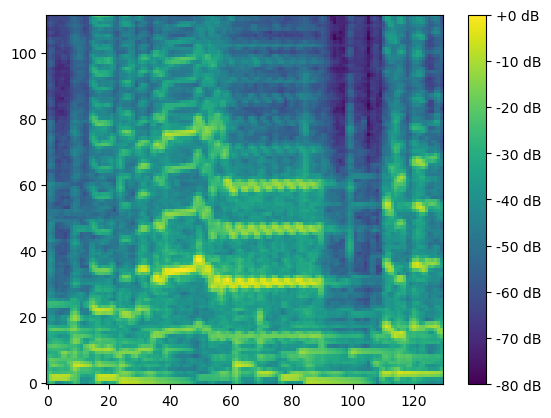

sum of dataset: 2
groundtruth:  88
bpm_librosa:  80.74951
genre:  7
input shape: (112, 130)


In [1]:
import audio_import as ai
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
from concurrent.futures import ProcessPoolExecutor
from sklearn.utils import shuffle
import random
import snntorch as snn
import torch
import re


batch_size = 128
files_to_load = 5
SR = int(22050/2)

train_loader, val_loader, input_shape = ai.import_audio_get_loader(batch_size=batch_size, 
                                                             only_dataset=False, 
                                                             train_data_ratio=0.8, 
                                                             files_to_load=files_to_load,
                                                             sr=SR,
                                                             )

example_batch = next(iter(train_loader))
mel, groundtruth, librosa_bpm, genre = example_batch

single_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension

# librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
plt.imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.show()



print(f"sum of dataset: {len(train_loader) +len(val_loader)}")
print("groundtruth: ", groundtruth[0].cpu().numpy())
print("bpm_librosa: ", librosa_bpm[0].cpu().numpy())
print("genre: ", genre[0].cpu().numpy())
print(f"input shape: {input_shape}")



In [12]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

class BPMEstimator(nn.Module):
    def __init__(self, input_shape):
        super(BPMEstimator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Compute the size after conv and pooling layers
        self.fc1_input_size = self.compute_flattened_size(input_shape)

        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # downsample by half
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # downsample by half
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def compute_flattened_size(self, input_shape):
        dummy_tensor = torch.ones(1, 1, *input_shape)  # Create a dummy batch with a batch size of 1 and 1 channel
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        _, c, h, w = x.shape
        return c * h * w



model = BPMEstimator(input_shape)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch_losses = []
validation_losses = []

In [13]:
import matplotlib.pyplot as plt
import time

epochs = 110

train_dataset = train_loader.dataset
val_dataset = val_loader.dataset

new_batch_size = 512  # or whatever value you want

train_loader = DataLoader(train_dataset, batch_size=new_batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=new_batch_size, shuffle=False, drop_last=False)


start_time = time.time()
start_time_all = time.time()
for epoch in range(epochs):
    epoch_loss = 0  # Resetting the epoch loss for each epoch
    
    model.train()
    for data, target, _ , _ in train_loader:
        optimizer.zero_grad()
        outputs = model(data).squeeze()  # Squeeze out the redundant dimension
        loss = criterion(outputs, target.float())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_epoch_loss:.4f} took {time.time() - start_time:.2f} seconds")
    start_time = time.time()

    
    # # Calculate validation loss
    # model.eval()
    # with torch.no_grad():
    #     val_loss = 0
    #     for data, target in test_loader:
    #         outputs = model(data).squeeze()
    #         loss = criterion(outputs, target.float())
    #         val_loss += loss.item()
    #     mean_val_loss = val_loss / len(test_loader)
    #     validation_losses.append(mean_val_loss)

    # print(f"Epoch {epoch+1}/{epochs}, Training Loss: {mean_epoch_loss:.4f} took {time.time() - start_time:.2f} seconds")
endtime = time.time() - start_time_all
print(f"{epochs} epochs took {endtime/60.0} mins")

# Plot the loss over epochs
plt.plot(epoch_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Epoch 1/110, Training Loss: 9188.5413 took 41.99 seconds
Epoch 2/110, Training Loss: 2554.4236 took 43.59 seconds
Epoch 3/110, Training Loss: 1828.2096 took 40.89 seconds
Epoch 4/110, Training Loss: 1600.8739 took 43.60 seconds
Epoch 5/110, Training Loss: 1554.1034 took 44.51 seconds


KeyboardInterrupt: 

In [8]:
# Save the model
model_save_path = "BPMEstimator_ballroom_big.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to BPMEstimator_ballroom_big.pth


In [214]:
# load the model
model_save_path = "BPMEstimator_ballroom.pth"
model = BPMEstimator(input_shape)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [3]:
# one step cnn

import torch
import torch.nn as nn
import torch.nn.functional as F

class MFModule(nn.Module):
    """ Multi-filter module """
    def __init__(self):
        super(MFModule, self).__init__()
        
        self.avg_pool = nn.AvgPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0))  # Adjust kernel size based on requirements
        self.batch_norm = nn.BatchNorm2d(16)
        
        # Parallel convolutional layers
        # self.conv_layers = nn.ModuleList([
        #     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 32)),
        #     nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 64)),
        #     nn.Conv2d(in_channels=16, out_channels=96, kernel_size=(1, 96)),
        #     nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1, 128)),
        #     # nn.Conv2d(in_channels=16, out_channels=192, kernel_size=(1, 192)),
        #     # nn.Conv2d(in_channels=16, out_channels=256, kernel_size=(1, 256))
        # ])
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 32), stride=1, padding=(0, 15)),  # padding = (kernel_size - 1) / 2
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(1, 16), stride=1, padding=(0, 7)),   # padding = (kernel_size - 1) / 2
            nn.Conv2d(in_channels=16, out_channels=96, kernel_size=(1, 8), stride=1, padding=(0, 3)),    # padding = (kernel_size - 1) / 2
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(1, 4), stride=1, padding=(0, 1)),   # padding = (kernel_size - 1) / 2
        ])

        self.bottleneck = nn.Conv2d(in_channels=320, out_channels=16, kernel_size=(1, 1))
        
    def forward(self, x):
        x = self.avg_pool(x)
        x = self.batch_norm(x)
        
        conv_outs = [F.elu(conv(x)) for conv in self.conv_layers]
        x = torch.cat(conv_outs, dim=1)
        
        x = self.bottleneck(x)
        return x


class TemporalCNN(nn.Module):
    def __init__(self):
        super(TemporalCNN, self).__init__()
        
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 5), padding=(0, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 5), padding=(0, 2))
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 5), padding=(0, 2))
        
        # Multi-filter modules
        self.mf_mods = nn.ModuleList([MFModule() for _ in range(4)])
        
        # Fully connected layers
        self.fc1 = nn.Linear(258048, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 256)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        
        for mf_mod in self.mf_mods:
            x = mf_mod(x)
        
        # Flattening the tensor before feeding to fully connected layers
        x = torch.flatten(x, 1)
        
        x = self.dropout(F.elu(self.fc1(x)))
        x = F.elu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        return x

model = TemporalCNN()
print(model)

# Loss and optimizer
criterion_2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# If GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20  # Adjust as needed

for epoch in range(num_epochs):
    for batch_idx, (data, targets, _, _) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(data).squeeze()
        loss = criterion_2(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


TemporalCNN(
  (conv1): Conv2d(1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
  (conv2): Conv2d(16, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
  (conv3): Conv2d(16, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
  (mf_mods): ModuleList(
    (0-3): 4 x MFModule(
      (avg_pool): AvgPool2d(kernel_size=(3, 1), stride=1, padding=(1, 0))
      (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_layers): ModuleList(
        (0): Conv2d(16, 32, kernel_size=(1, 32), stride=(1, 1), padding=(0, 15))
        (1): Conv2d(16, 64, kernel_size=(1, 16), stride=(1, 1), padding=(0, 7))
        (2): Conv2d(16, 96, kernel_size=(1, 8), stride=(1, 1), padding=(0, 3))
        (3): Conv2d(16, 128, kernel_size=(1, 4), stride=(1, 1), padding=(0, 1))
      )
      (bottleneck): Conv2d(320, 16, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (fc1): Linear(in_features=258048, out_features=64, bias=True)
  (fc2): Linear(in_features

KeyboardInterrupt: 

In [10]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    correct = 0
    total = 0
    for data, targets, _ , _ in val_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data).squeeze()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

Accuracy on test data: 13.06%


In [2]:
# snn
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from snntorch import spikegen

import torch
import torch.nn as nn
from torchvision import datasets, transforms

dtype = torch.float32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


spike_grad = surrogate.fast_sigmoid(slope=25)

class SpikingBPMEstimator(nn.Module):
    def __init__(self, input_shape, beta=0.95, num_steps=50):
        super(SpikingBPMEstimator, self).__init__()
        
        # Define the Conv Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        # Compute the size after conv and pooling layers
        dummy_tensor = torch.ones(1, 1, *input_shape)
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        _, c, h, w = x.shape
        self.fc1_input_size = c * h * w

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.fc2 = nn.Linear(128, 1)
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        
        self.num_steps = num_steps

    def forward(self, x):
        orig_x = x  # Store the initial input
        # Initialize the hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        # Record the spikes
        spk4_rec = []

        for step in range(self.num_steps):
            # Conv Layer 1
            x = self.conv1(orig_x)  # Use the stored tensor here
            spk1, mem1 = self.lif1(x, mem1)
            x = F.max_pool2d(spk1, 2)

            # Conv Layer 2
            x = self.conv2(x)
            spk2, mem2 = self.lif2(x, mem2)
            x = F.max_pool2d(spk2, 2)
            
            # Flatten and Pass through FC Layers
            x = x.view(x.size(0), -1)
            
            x = self.fc1(x)
            spk3, mem3 = self.lif3(x, mem3)
            
            x = self.fc2(spk3)
            spk4, mem4 = self.lif4(x, mem4)
            
            spk4_rec.append(spk4)

        return torch.stack(spk4_rec, dim=0)

print(input_shape)
spiking_model = SpikingBPMEstimator(input_shape).to(device)

# Define a loss function and an optimizer
loss_fn = nn.MSELoss()  # or any other appropriate loss function
optimizer = torch.optim.Adam(spiking_model.parameters(), lr=0.001)

data, targets, bpm_lib, genre = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_rec, mem_rec = spiking_model(data)

# 50 time steps, 10 samples of data, 4 output neurons
print(mem_rec.size())



WARNING    /tmp/ipykernel_77183/1643559335.py:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop
 [py.warnings]


(112, 130)


: 

: 

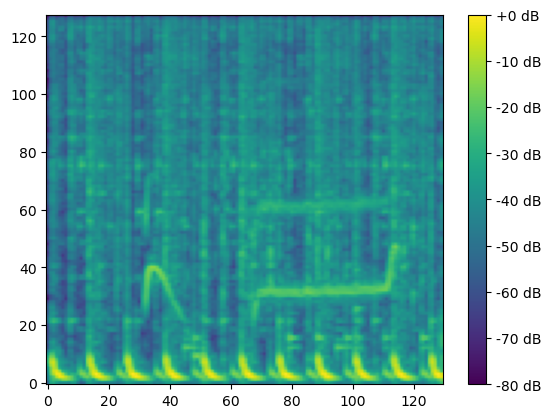

Librosa BPM Estimate: 107.67
0 

1 

2 

4 

5 

6 

7 

8 

9 

10 



ValueError: operands could not be broadcast together with shapes (974,) (974,256) 

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

data, targets, librosa_bpm, _ = next(iter(train_loader))

single_mel = data[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension

# librosa.display.specshow(librosa.power_to_db(data, ref=np.max), y_axis='mel', x_axis='time')
plt.imshow(librosa.power_to_db(single_mel, ref=np.max), origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.show()


print(f"Librosa BPM Estimate: {librosa_bpm[0]:.2f}")


# Set model to evaluation mode
model.eval()

all_predictions = []
all_true_labels = []
librosa_bpm_estimates = []  # List to store Librosa's BPM estimates
all_genre = []  # List to store Librosa's BPM estimates


# No gradient is needed during evaluation/inference
cnt = 0
with torch.no_grad():
    for data, target, librosa_bpm, genre in val_loader:
        outputs = model(data)
        predictions = outputs
        all_predictions.extend(predictions.cpu().numpy()) 
        all_true_labels.extend(target.cpu().numpy())
        librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())
        all_genre.extend(genre.cpu().numpy())
        



# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_genre = np.array(all_genre)
librosa_bpm_estimates = np.array(librosa_bpm_estimates)


unique_time_sigs = set(all_genre)
for time_sig in unique_time_sigs:
    print(time_sig, "\n")

 #sub_dirs = ['1_4', '2_4', '3_4', '4_4', '5_4', '7_8']

time_signature_colors = {
    # 0 : 'red',
    # 1 : 'blue',
    # 2 : 'yellow',
    # 3 : 'purple',
    # 4 : 'cyan',
    # 5 : 'black',    # ... add other time signatures as needed
    # 6 : 'black',    # ... add other time signatures as needed
    # 7 : 'black',    # ... add other time signatures as needed
    # 8 : 'black',    # ... add other time signatures as needed
    # 9 : 'black',    # ... add other time signatures as needed
    # 10 : 'black',    # ... add other time signatures as needed
    0 : 'red',
    1 : 'red',
    2 : 'red',
    3 : 'red',
    4 : 'red',
    5 : 'red',    # ... add other time signatures as needed
    6 : 'red',    # ... add other time signatures as needed
    7 : 'red',    # ... add other time signatures as needed
    8 : 'red',    # ... add other time signatures as needed
    9 : 'red',    # ... add other time signatures as needed
    10 : 'red',    # ... add other time signatures as needed
}

mask = (all_genre != 5) & (all_genre != 4)# This skips all points with time signature 2

all_predictions = all_predictions[mask]
all_true_labels = all_true_labels[mask]
all_genre = all_genre[mask]
librosa_bpm_estimates = librosa_bpm_estimates[mask]


# Residual plot
# model_residuals = all_true_labels - all_predictions
# librosa_residuals = all_true_labels - librosa_bpm_estimates  # Residuals for Librosa's BPM estimates

# # Calculate the linear fit for model's residuals
# from sklearn.linear_model import LinearRegression

# # Training a linear regressor on original predictions to predict residuals
# calibration_model = LinearRegression()
# calibration_model.fit(all_predictions.reshape(-1, 1), model_residuals)

# # Adjust predictions
# adjustment = calibration_model.predict(all_predictions.reshape(-1, 1))
# print(f"Adjustment: {adjustment.mean():.2f}")
# adjusted_predictions = all_predictions + adjustment



# 2. Map the time signatures to colors
scatter_colors = [time_signature_colors[timesig] for timesig in all_genre]



# model_mae = np.mean(np.abs(model_residuals))
# librosa_mae = np.mean(np.abs(librosa_residuals))

# labels = ['Model', 'Librosa']
# errors = [model_mae, librosa_mae]

# plt.figure(figsize=(8, 6))
# plt.bar(labels, errors, color=['red', 'green'])
# plt.xlabel('Method')
# plt.ylabel('Mean Absolute Error')
# plt.title('Comparison of Mean Absolute Errors')
# plt.show()

tolerance = 5.0  # Define your acceptable range e.g., if you want predictions within 5 BPM of true value, set X to 5.
correct_predictions = np.abs(all_true_labels - all_predictions) <= tolerance
correct_predictions_lib = np.abs(all_true_labels - librosa_bpm_estimates) <= tolerance
accuracy = np.mean(correct_predictions) * 100  # This gives the percentage of predictions within the defined range.
accuracy_lib = np.mean(correct_predictions_lib) * 100  # This gives the percentage of predictions within the defined range.
print(f"Model accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")

# adjusted_predictions = all_predictions - expected_residuals

# Scatter plot
plt.figure(figsize=(8, 8))
# plt.scatter(all_true_labels, adjusted_predictions, alpha=0.3, color="b", label='Adjusted Model Predictions')
plt.scatter(all_true_labels, all_predictions, color=scatter_colors, alpha=0.3, label='Model Predictions')
plt.scatter(all_true_labels, librosa_bpm_estimates, alpha=0.3, color='green', label='Librosa Estimates')  # Plotting Librosa's BPM estimates in green
plt.plot([all_true_labels.min(), all_true_labels.max()], 
         [all_true_labels.min(), all_true_labels.max()], 
         'k--', lw=2)
# plt.plot(x, y, 'b--', label='Fit Line')
# plt.scatter(all_true_labels, model_residuals, alpha=0.5, color='r', label='Model Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f"Model accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")
plt.legend()
plt.grid(True)
plt.show()



# plt.figure(figsize=(8, 8))
# plt.scatter(all_true_labels, model_residuals, alpha=0.5, color=scatter_colors, label='Model Residuals')
# plt.scatter(all_true_labels, librosa_residuals, alpha=0.5, color='green', label='Librosa Residuals')  # Plotting residuals for Librosa's BPM estimates in green
# plt.axhline(y=0, color='k', linestyle='--', lw=2)
# plt.xlabel('True Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.legend()
# plt.grid(True)
# plt.show()
